# 5. Clustering and Manifold Learning (Niall)

### Importing modules, data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)

#### Scatterplot function
From lab 6

In [2]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot

def clustering_scatterplot(points, labels, centers, title):
    # plot the examples, i.e. the data points
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [3]:
dfCluster = pd.read_json("./russian_ads.json")

### (Data Prep) Converting lists into tuples, numbers

In [4]:
listCols = ['language_categories', 'placement_categories', 'interests_categories', 'location_categories']
dateCols = ['month', 'year']
numCols = ['age_lower', 'age_upper', 'ad_impressions', 'ad_clicks', 'ad_spend_usd', 'month', 'year']

for col in listCols:
    dfCluster[col] = dfCluster[col].transform(tuple)

for col in dateCols:
    dfCluster[col] = dfCluster[col].apply(''.join).astype(int)
    
for col in numCols:
    dfCluster[col] = pd.to_numeric(dfCluster[col], errors='coerce')
    
dfCluster.head(1)

,language_categories,placement_categories,interests_categories,location_categories,ad_id,ad_copy,ad_landing_page,ad_targeting_location,age_lower,age_upper,age,placements,ad_impressions,ad_clicks,ad_spend_rub,ad_creation_date,month,year,day,ad_end_date,extra_data,pdf_filepath,image_filepath,interest_expansion,excluded_connections,language,ad_spend_usd,efficiency_impressions,efficiency_clicks,conversion_rate,interests_categories_regex,location_categories_regex,date_order_index
0,"(Not Specified,)","(Facebook,)",(),"(Midwest, Atlantic)",331.0,"""Free Figure's Black Power Rally at VCU:""",https://www.facebook.com/Black-Matters-1579673...,"United States: Baltimore Maryland: Ferguson, S...",18.0,999.0,18-65+,News Feed on desktop computers or News Feed on...,764.0,43,90.86,06/15/2015,6,2015,15,06/16/2015,Completed at the Direction of Ranking Memberof...,2015-06/P10002117.pdf,missing_ad.png,None,None,None,1.66,460.24,25.9,0.06,,Midwest_Atlantic,41


### Making a dataset out of numeric fields

In [5]:
dfNum = dfCluster[['age_lower', 'age_upper', 'ad_impressions', 'ad_clicks', 'ad_spend_usd', 'month', 'year']]
dfNum['ad_id'] = range(1, len(dfNum) + 1)

dfNum = dfNum.dropna()
num_data = np.array(dfNum.values, dtype=float)

# cluster_data = np.array(dfNum.values, dtype=float)
# print('(number of examples, number of attributes): ', cluster_data.shape)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Encoding interesting categorical fields into numbers

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

cols = ['placement_categories', 'interests_categories', 'location_categories']
dfEncoded = dfCluster[cols]
for col in cols:
    mlb = MultiLabelBinarizer()
    dfEncoded = dfEncoded.join(pd.DataFrame(mlb.fit_transform(dfEncoded.pop(col)),
                                            columns=mlb.classes_,
                                            index=dfEncoded.index))

dfEncoded['ad_id'] = range(1, len(dfEncoded) + 1)
dfEncoded.head(1)

,Facebook,Instagram,Third Party Apps,Video,Above Age 30,African American,American South,Anti-Immigrant,Army,Below Age 30,Christianity,Conservative,Geographic,Gun Rights,Islam,LGBTQ,Latinx,Memes,Memes and Products,Native American,Patriotism,Police,Prison,Products,Progressive,Self-Defense,Texas,Unknown,Atlantic,Midwest,Non-US,Northeast,Pacific,Southwest,The South,ad_id
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


In [7]:
dfNumEncode = pd.merge(dfNum, dfEncoded, on='ad_id', how='inner').dropna()
dfNumEncode.drop(['ad_id'], axis=1, inplace=True)
dfNumEncode.head(1)

,age_lower,age_upper,ad_impressions,ad_clicks,ad_spend_usd,month,year,Facebook,Instagram,Third Party Apps,Video,Above Age 30,African American,American South,Anti-Immigrant,Army,Below Age 30,Christianity,Conservative,Geographic,Gun Rights,Islam,LGBTQ,Latinx,Memes,Memes and Products,Native American,Patriotism,Police,Prison,Products,Progressive,Self-Defense,Texas,Unknown,Atlantic,Midwest,Non-US,Northeast,Pacific,Southwest,The South
0,18.0,999.0,764.0,43,1.66,6,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


### Combining these into a dataframe and array

In [8]:
numEncode_data = np.array(dfNumEncode.values, dtype=float)
print('(number of examples, number of attributes): ', numEncode_data.shape)

(number of examples, number of attributes):  (2726, 42)


### Scaling the data

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
numEncode_data = min_max_scaler.fit_transform(numEncode_data)

### K-means Clustering

In [10]:
k = 3
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(numEncode_data)

### Best Value of k?

#### Elbow Method

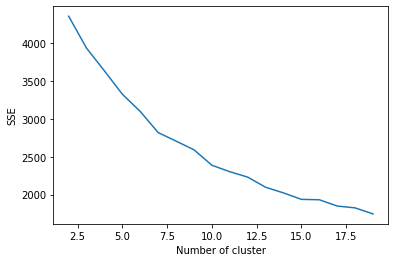

In [11]:
sse = {}
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(numEncode_data)
    #numEncode_data['clusters'] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### Silhouette Coefficient Method

In [12]:
for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(numEncode_data)
    label = kmeans.labels_
    sil_coeff = silhouette_score(numEncode_data, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.18669838525120822
For n_clusters=3, The Silhouette Coefficient is 0.18768431601823915
For n_clusters=4, The Silhouette Coefficient is 0.2085469226230702
For n_clusters=5, The Silhouette Coefficient is 0.24215443353569424
For n_clusters=6, The Silhouette Coefficient is 0.24131822649123486
For n_clusters=7, The Silhouette Coefficient is 0.277174402672209
For n_clusters=8, The Silhouette Coefficient is 0.29234422775766233
For n_clusters=9, The Silhouette Coefficient is 0.2746107406096257
For n_clusters=10, The Silhouette Coefficient is 0.31756578776966937
For n_clusters=11, The Silhouette Coefficient is 0.3223164709058296
For n_clusters=12, The Silhouette Coefficient is 0.32473602530533496
For n_clusters=13, The Silhouette Coefficient is 0.3459549897136431
For n_clusters=14, The Silhouette Coefficient is 0.36502676986002863
For n_clusters=15, The Silhouette Coefficient is 0.3658821353050761
For n_clusters=16, The Silhouette Coefficient is 

## Manifold Learning

In [13]:
# append the cluster centers to the dataset
numEncode_data_and_centers = np.r_[numEncode_data, clustered_data_sklearn.cluster_centers_]

###  Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space¶

In [14]:
# project both th data and the k-Means cluster centers to a 2D space
XYcoordinates = manifold.MDS(n_components=2).fit_transform(numEncode_data_and_centers)
print("transformation complete")

transformation complete


In [15]:
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2710 but corresponding boolean dimension is 2726

### Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

In [ ]:
# project both th data and the k-Means cluster centers to a 2D space
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(numEncode_data_and_centers)
print("transformation complete")

In [ ]:
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
# plot the transformed examples and the centers
# use the cluster assignment to colour the examples
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

## Clutster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [ ]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=dfNumEncode.index)

In [ ]:
df.head()

In [ ]:
dfNumEncode.groupby('cluster').mean()